<a href="https://colab.research.google.com/github/Bindu32/dynamic-pricing-parking/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dynamic Pricing for Urban Parking Lots**
Capstone Project of Summer Analytics 2025 hosted by Consulting & Analytics Club × Pathway

In [1]:
!pip install pathway bokeh --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Importing Libraries

In [2]:
import numpy as np # Data Analysis
import pandas as pd # Data Manipulation
import matplotlib.pyplot as plt # Data Visualization
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

# Step 1: Importing and Preprocessing the Data

In [3]:
df = pd.read_csv('dataset.csv')

In [5]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [6]:
df.describe()

,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [8]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [9]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity"]].to_csv("parking_stream.csv", index=False)

# Model 1 – Baseline Linear Pricing Model

In [10]:
# Baseline Model 1: Linear price based on occupancy
def baseline_linear_pricing(df, alpha=2.0, base_price=10.0):
    df = df.copy()
    df['Price'] = base_price  # Start with base price

    for i in range(1, len(df)):
        occ = df.loc[i, 'Occupancy']
        cap = df.loc[i, 'Capacity']
        prev_price = df.loc[i-1, 'Price']

        # Apply linear formula
        new_price = prev_price + alpha * (occ / cap)

        # Optional: cap the price between $5 and $20
        new_price = max(5, min(20, new_price))

        df.loc[i, 'Price'] = new_price

    return df


In [11]:
# Filter for one parking lot to test
lot_id = 'BHMBCCMKT01'
lot_df = df[df['SystemCodeNumber'] == lot_id].reset_index(drop=True)

# Run the model
priced_df = baseline_linear_pricing(lot_df)

# Show few results
priced_df[['Timestamp', 'Occupancy', 'Price']].head(10)


,Timestamp,Occupancy,Price
0,2016-10-04 07:59:00,61,10.000000
1,2016-10-04 08:25:00,64,10.221837
2,2016-10-04 08:59:00,80,10.499133
3,2016-10-04 09:32:00,107,10.870017
4,2016-10-04 09:59:00,150,11.389948
5,2016-10-04 10:26:00,177,12.003466
6,2016-10-04 10:59:00,219,12.762565
7,2016-10-04 11:25:00,247,13.618718
8,2016-10-04 11:59:00,259,14.516464
9,2016-10-04 12:29:00,266,15.438475


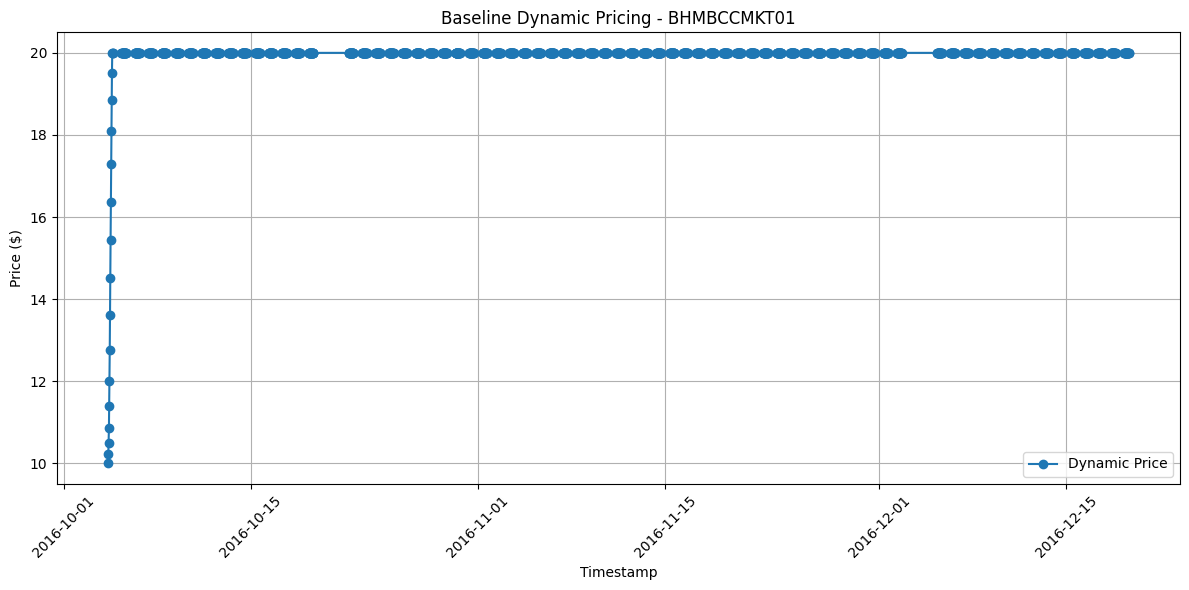

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(priced_df['Timestamp'], priced_df['Price'], marker='o', label='Dynamic Price')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title(f'Baseline Dynamic Pricing - {lot_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### This plot shows how the price changes over time based on occupancy using the baseline model.
### Once the calculated price reaches the upper cap of $20, it stays constant — hence the flat line.



# Model 2: Demand-Based Pricing

In [14]:
def demand_based_pricing(df, base_price=10.0, lam=0.5):
    df = df.copy()

    # Map Traffic Condition to numeric values
    traffic_map = {'low': 1, 'medium': 2, 'high': 3}
    df['TrafficValue'] = df['TrafficConditionNearby'].map(traffic_map)

    # Map Vehicle Type to weights
    vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5}
    df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)

    # Ensure required columns are present
    required_cols = ['Occupancy', 'Capacity', 'QueueLength', 'TrafficValue', 'IsSpecialDay', 'VehicleWeight']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    # Feature weights (tune these later)
    alpha = 0.4
    beta = 0.2
    gamma = 0.3
    delta = 0.4
    epsilon = 0.2

    # Compute raw demand
    df['DemandRaw'] = (
        alpha * (df['Occupancy'] / df['Capacity']) +
        beta * df['QueueLength'] -
        gamma * df['TrafficValue'] +
        delta * df['IsSpecialDay'] +
        epsilon * df['VehicleWeight']
    )

    # Normalize demand to 0–1
    min_d, max_d = df['DemandRaw'].min(), df['DemandRaw'].max()
    df['DemandNorm'] = (df['DemandRaw'] - min_d) / (max_d - min_d)

    # Calculate price
    df['Price'] = base_price * (1 + lam * df['DemandNorm'])

    # Clip price between $5 and $20
    df['Price'] = df['Price'].clip(5, 20)

    return df


In [15]:
# Filter for one parking lot
lot_df = df[df['SystemCodeNumber'] == 'BHMBCCMKT01'].reset_index(drop=True)

# Run Model 2
priced_df = demand_based_pricing(lot_df)

# View result
priced_df[['Timestamp', 'Occupancy', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Price']].head()


,Timestamp,Occupancy,QueueLength,TrafficConditionNearby,IsSpecialDay,VehicleType,Price
0,2016-10-04 07:59:00,61,1,low,0,car,10.716991
1,2016-10-04 08:25:00,64,1,low,0,car,10.721447
2,2016-10-04 08:59:00,80,2,low,0,car,11.173697
3,2016-10-04 09:32:00,107,2,low,0,car,11.213798
4,2016-10-04 09:59:00,150,2,low,0,bike,11.063419


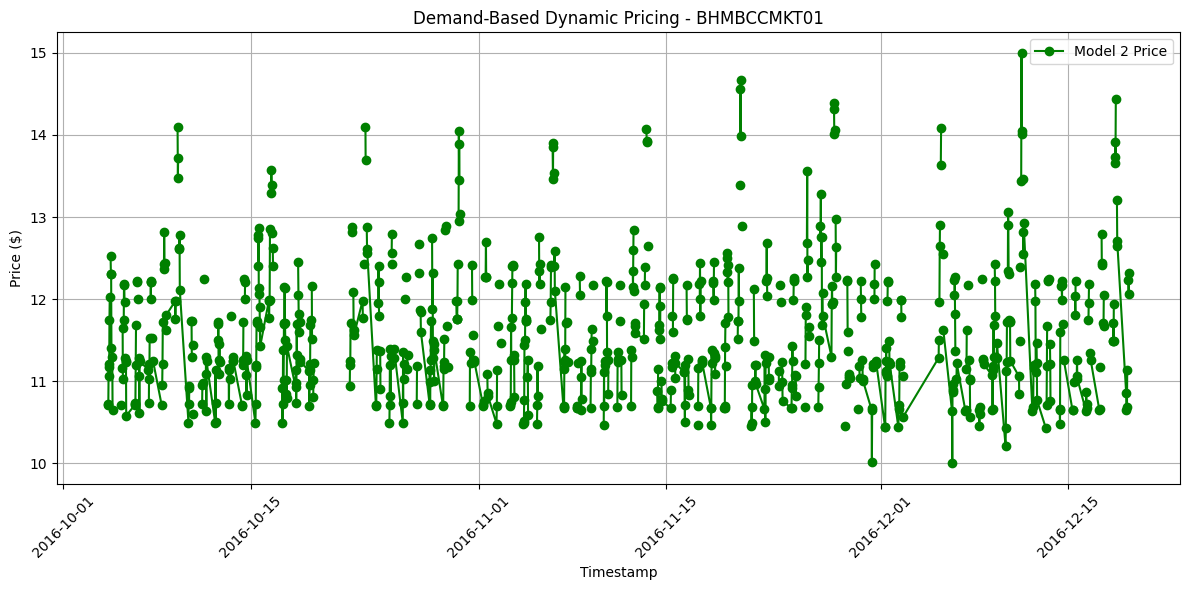

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(priced_df['Timestamp'], priced_df['Price'], marker='o', color='green', label='Model 2 Price')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title('Demand-Based Dynamic Pricing - BHMBCCMKT01')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
